Best Parameters꞉ {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 5, 'n_estimators': 100}
              precision    recall  f1-score   support

         acc       0.68      0.84      0.75        77
        good       1.00      0.07      0.12        15
       unacc       0.95      0.99      0.97       237
       vgood       1.00      0.12      0.21        17

    accuracy                           0.88       346
   macro avg       0.91      0.51      0.51       346
weighted avg       0.89      0.88      0.85       346

0.9337283410998974
Best Parameters:{'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 620}
              precision    recall  f1-score   support

           0       0.96      0.92      0.94        77
           1       0.71      0.67      0.69        15
           2       1.00      0.99      1.00       237
           3       0.70      0.94      0.80        17

    accuracy                           0.96   

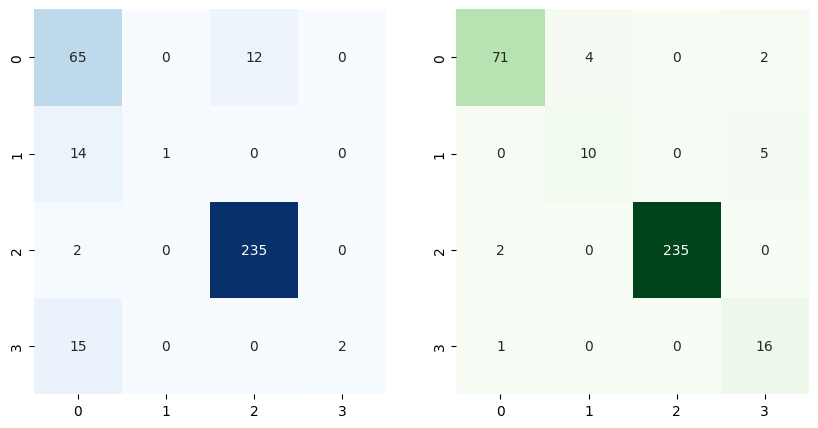

In [6]:
import pandas as pd
import seaborn as sns
!pip install category_encoders
import matplotlib.pyplot as plt
from category_encoders import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')
from seaborn import heatmap
from sklearn.ensemble import RandomForestClassifier
import category_encoders as ce
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from xgboost import XGBRFClassifier

car_df = pd.read_csv("car_evaluation.csv")
car_df.columns = ['buying', 'meant', 'doors', 'persons', 'lug_boot', 'safety', 'class']

category_cols = ['buying', 'meant', 'doors', 'persons', 'lug_boot', 'safety']
encoder = ce.OneHotEncoder(cols=category_cols)
car_df = encoder.fit_transform(car_df)

X = car_df.drop(['class'], axis=1)
y = car_df['class']
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=4/5, random_state=42)

rf_param_grid = {
'n_estimators': [i for i in range(100, 200, 50)],
'min_samples_leaf': [5, 10, 20],
'max_features': ['log2', 'None', 'sqrt'],
'max_depth': [4, 6, 10]
}

rf_model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf_model, param_grid=rf_param_grid,
cv=5, n_jobs=-1, verbose=0, scoring='accuracy')

grid_search.fit(X_train, y_train)

best_parameters = grid_search.best_params_
print(f"Best Parameters꞉ {best_parameters}")

tuned_rf_model = RandomForestClassifier(max_features='log2',
min_samples_leaf=10,
n_estimators=100,
max_depth=10,
random_state=42)

tuned_rf_model.fit(X_train, y_train)
y_pred_rf = tuned_rf_model.predict(X_test)
print(classification_report(y_test, y_pred_rf))
#####1
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues', cbar=False)
print(roc_auc_score(y_test, tuned_rf_model.predict_proba(X_test), multi_class='ovo'))

xgbrf_model = XGBRFClassifier(random_state=42)
xgbrf_param_grid = {
'n_estimators': [i for i in range(100, 1000, 40)],
'max_depth': [4, 6, 8, 10],
'min_child_weight': [1, 2, 4],
'colsample_bytree': [0.5],
'learning_rate': [0.01, 0.05, 0.1]}

grid_search = GridSearchCV(estimator=xgbrf_model, param_grid=xgbrf_param_grid,
cv=5, n_jobs=-1, verbose=0, scoring='accuracy')
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
grid_search.fit(X_train, y_train_encoded)
best_parameters = grid_search.best_params_
print(f"Best Parameters:{best_parameters}")

tuned_xgbrf_model = XGBRFClassifier(n_estimators=380, learning_rate=0.01,
max_depth=10,cosample_bytree=0.5 ,min_child_weight=1)
tuned_xgbrf_model.fit(X_train, y_train_encoded)

tuned_xgbrf_model.fit(X_train, y_train_encoded)
y_pred_xgb = tuned_xgbrf_model.predict(X_test)
print(classification_report(y_test_encoded,y_pred_xgb))
plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(y_test_encoded, y_pred_xgb), annot=True, fmt='d', cmap='Greens', cbar=False)
print(roc_auc_score(y_test, tuned_xgbrf_model.predict_proba(X_test), multi_class='ovo'))
